In [1]:
import jax
import jax.numpy as jnp
import jax.random as jrandom
from jax.random import PRNGKey
from jax import Array
import os
jax.devices() # Should be cuda
_ = os.system("nvidia-smi  --query-gpu=name --format=csv,noheader") # Should show GPU info

In [2]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import pandas as pd

from functools import partial
from typing import Tuple, List, Optional

import haiku as hk # Neural network library
import optax # Gradient-based optimization in JAX

import numpy as np

# Some small helper functions
from probjax.nn.transformers import Transformer
from probjax.nn.helpers import GaussianFourierEmbedding
from probjax.nn.loss_fn import denoising_score_matching_loss
from probjax.distributions.sde import VESDE
from probjax.distributions import Empirical, Independent

from scoresbibm.utils.plot import use_style

from sbi.analysis import pairplot
import numpy as np

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [3]:
# Set random key
key = jax.random.PRNGKey(0)

In [64]:
import numpy as np
import pandas as pd
from scipy.stats import wasserstein_distance, ks_2samp, entropy
from sklearn.metrics import mutual_info_score
from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import jensenshannon
from scipy.stats import pearsonr

def compute_distribution_similarity(original_data, generated_data):
    """
    Compute multiple metrics to assess distribution similarity with NaN handling
    
    Parameters:
    -----------
    original_data : numpy.ndarray
        Original data samples
    generated_data : numpy.ndarray
        Generated data samples
    
    Returns:
    --------
    dict : Dictionary of similarity scores and data quality metrics
    """
    # Ensure same number of dimensions
    assert original_data.shape[1] == generated_data.shape[1], "Data must have same number of dimensions"
    
    # Initialize similarity scores
    similarity_scores = {}
    
    # Track data quality metrics
    similarity_scores['nan_percentage'] = {
        'original': np.mean(np.isnan(original_data)) * 100,
        'generated': np.mean(np.isnan(generated_data)) * 100
    }
    
    # Function to safely compute metrics handling NaN values
    def safe_metric(func, x, y, *args, **kwargs):
        # Remove paired NaN values
        mask = ~(np.isnan(x) | np.isnan(y))
        if np.sum(mask) < 2:  # Need at least 2 points for comparison
            return np.nan
        return func(x[mask], y[mask], *args, **kwargs)
    
    # 1. Wasserstein Distance with NaN handling
    wasserstein_scores = []
    for dim in range(original_data.shape[1]):
        was_dist = safe_metric(wasserstein_distance,
                             original_data[:, dim],
                             generated_data[:, dim])
        wasserstein_scores.append(was_dist)
    similarity_scores['wasserstein_distance'] = np.nanmean(wasserstein_scores)
    
    # 2. Kolmogorov-Smirnov Test with NaN handling
    ks_scores = []
    ks_pvalues = []
    for dim in range(original_data.shape[1]):
        try:
            ks_stat, ks_pval = safe_metric(ks_2samp,
                                         original_data[:, dim],
                                         generated_data[:, dim])
            ks_scores.append(ks_stat)
            ks_pvalues.append(ks_pval)
        except:
            ks_scores.append(np.nan)
            ks_pvalues.append(np.nan)
    similarity_scores['ks_statistic'] = np.nanmean(ks_scores)
    similarity_scores['ks_pvalue'] = np.nanmean(ks_pvalues)
    
    # 3. Jensen-Shannon Divergence
    js_scores = []
    for dim in range(original_data.shape[1]):
        try:
            # Create histograms for JSD calculation
            hist1, bins = np.histogram(original_data[:, dim][~np.isnan(original_data[:, dim])], 
                                     bins=50, density=True)
            hist2, _ = np.histogram(generated_data[:, dim][~np.isnan(generated_data[:, dim])], 
                                  bins=bins, density=True)
            # Add small constant to avoid zero probabilities
            hist1 = hist1 + 1e-10
            hist2 = hist2 + 1e-10
            # Normalize
            hist1 = hist1 / hist1.sum()
            hist2 = hist2 / hist2.sum()
            js_div = jensenshannon(hist1, hist2)
            js_scores.append(js_div)
        except:
            js_scores.append(np.nan)
    similarity_scores['jensen_shannon_divergence'] = np.nanmean(js_scores)
    
    # 4. Correlation Analysis
    corr_scores = []
    for dim in range(original_data.shape[1]):
        try:
            corr, _ = safe_metric(pearsonr,
                                original_data[:, dim],
                                generated_data[:, dim])
            corr_scores.append(abs(corr))  # Use absolute correlation
        except:
            corr_scores.append(np.nan)
    similarity_scores['correlation'] = np.nanmean(corr_scores)
    
    # 5. Distribution Statistics Comparison
    stat_metrics = {}
    for dim in range(original_data.shape[1]):
        orig_stats = pd.Series(original_data[:, dim]).describe()
        gen_stats = pd.Series(generated_data[:, dim]).describe()
        
        for stat in ['mean', 'std', '25%', '50%', '75%']:
            diff = abs(orig_stats[stat] - gen_stats[stat])
            if stat not in stat_metrics:
                stat_metrics[stat] = []
            stat_metrics[stat].append(diff)
    
    for stat, values in stat_metrics.items():
        similarity_scores[f'stat_diff_{stat}'] = np.nanmean(values)
    
    # 6. Overall Similarity Score (weighted combination)
    # Lower score indicates better similarity
    weights = {
        'wasserstein': 0.3,
        'ks': 0.2,
        'jsd': 0.2,
        'correlation': 0.3
    }
    
    similarity_scores['overall_similarity'] = (
        weights['wasserstein'] * similarity_scores['wasserstein_distance'] +
        weights['ks'] * (1 - similarity_scores['ks_pvalue']) +
        weights['jsd'] * similarity_scores['jensen_shannon_divergence'] +
        weights['correlation'] * (1 - similarity_scores['correlation'])
    )
    
    return similarity_scores

### 1) Setting up a toy problem

This is a simple toy problem to test the functionality of the `Simformer` method.
$$ \theta \sim \mathcal{N}(\theta; 0, 3^2) \qquad \qquad  x_1 \sim \mathcal{N}(x_1; 2\cdot\sin(\theta), 0.5^2)  \qquad \qquad   x_2 \sim \mathcal{N}(x_2;0.1\cdot \theta^2,  (0.5\cdot |x_1|)^2)$$

Here we have 3 nonlinear related Gaussian variables. The associated joint distirbution is visualized below.

In [91]:
import numpy as np
import pandas as pd
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import random

def generate_data(key: PRNGKey, n: int):
    key1, key2, key3, key4 = jrandom.split(key, 4)
    
    # Generate base data
    theta1 = jrandom.normal(key1, (n, 1)) * 3
    x1 = 2 * jnp.sin(theta1) + jrandom.normal(key2, (n, 1)) * 0.5
    x2 = 0.1 * theta1**2 + 0.5 * jnp.abs(x1) * jrandom.normal(key3, (n, 1))
    
    # Create probability mask based on data values rather than array position
    # Higher probability of NaN values in the tails of the distributions
    
    # For theta1: More NaNs in the tails of the normal distribution
    theta_probs = jnp.exp(-0.5 * (theta1/3)**2)  # Inverse of normal distribution density
    theta_probs = (theta_probs - theta_probs.min()) / (theta_probs.max() - theta_probs.min())
    
    # For x1: More NaNs where sin(theta1) approaches ±1
    x1_probs = jnp.abs(jnp.sin(theta1))
    x1_probs = (x1_probs - x1_probs.min()) / (x1_probs.max() - x1_probs.min())
    
    # For x2: More NaNs at larger values due to quadratic relationship
    x2_probs = jnp.abs(x2)
    x2_probs = (x2_probs - x2_probs.min()) / (x2_probs.max() - x2_probs.min())
    
    # Combine probabilities for x1 and x2
    nan_probs = jnp.concatenate([theta_probs, x1_probs, x2_probs], axis=1)
    
    # Generate random values and create NaN mask
    random_mask = jrandom.uniform(key4, (n, 3))
    nan_mask = random_mask < nan_probs * 0.3  # Adjust the 0.3 to control overall NaN density
    
    # Combine data and apply mask
    data = jnp.concatenate([theta1, x1, x2], axis=1).reshape(n, -1, 1)
    data = jnp.where(nan_mask[..., None], jnp.nan, data)
    
    return data

n = 1000
# Example usage of the function with real data and logAge
data= generate_data(key, n)
print(data.shape)
# Calculate the number of nodes (data points)
nodes_max = data.shape[1]

# Create node IDs for each data point
node_ids = jnp.arange(nodes_max)
    
# important here amount of data does it change something ?
data = generate_data(jrandom.PRNGKey(1), n)  # Shape: (n, nodes, dim) here dim = 1
# nodes max = how many data points
nodes_max = data.shape[1]
# creates id for notes ?
node_ids = jnp.arange(nodes_max)

(1000, 3, 1)


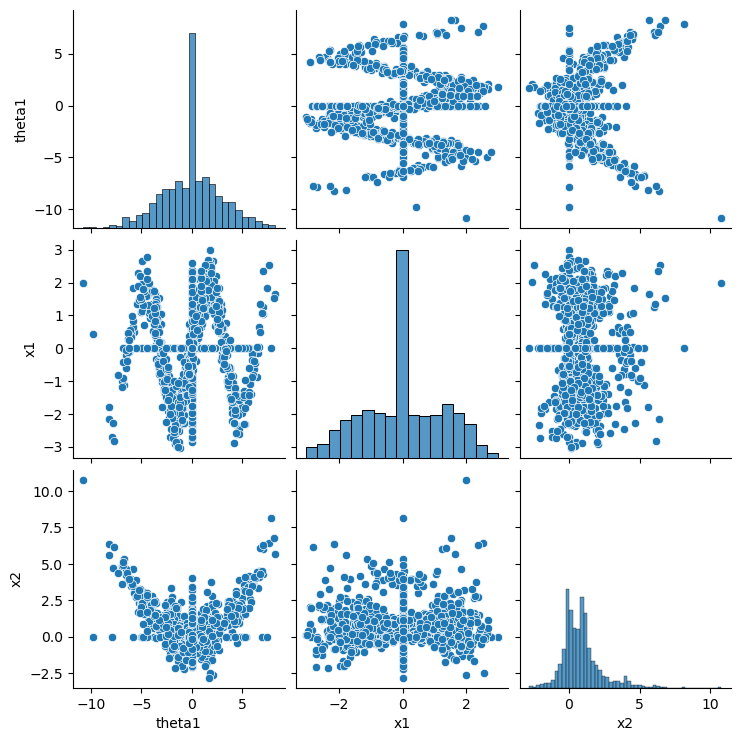

c:\Users\Alexm\anaconda3\Lib\site-packages\sbi\inference\trainers\npe\npe_base.py:169: UserWarning: Beware that there is only a single unique element in the simulated data. If this is intended, make sure to set `z_score_x='none'` as z-scoring would result in NaNs
  warn_if_zscoring_changes_data(x)


 Neural network successfully converged after 144 epochs.

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

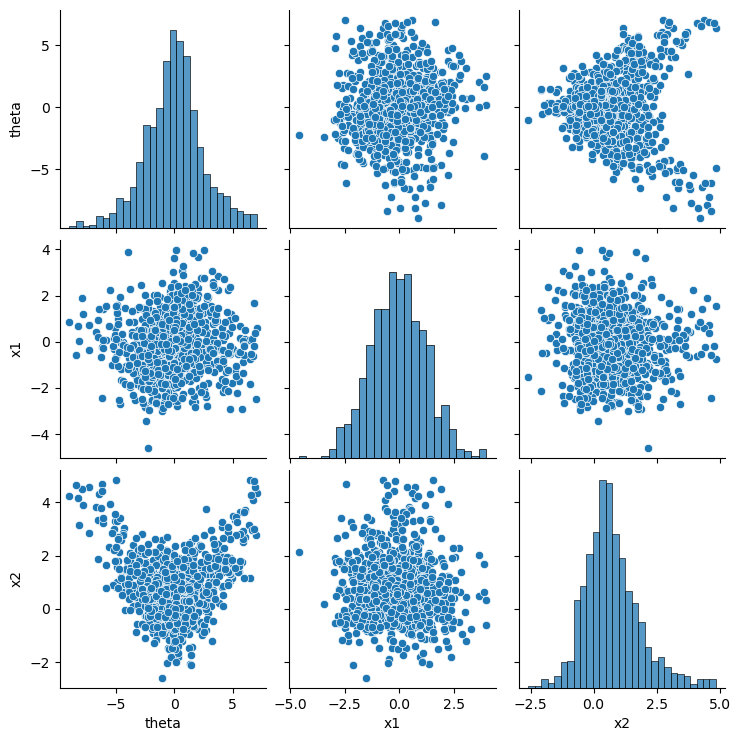

Distribution Similarity Metrics:
nan_percentage: {'original': 14.7, 'generated': 0.0}
wasserstein_distance: 0.3725062323226553
ks_statistic: 0.10007507352058069
ks_pvalue: 0.0005447645541911703
jensen_shannon_divergence: 0.16104159055659997
correlation: 0.0321755568899089
stat_diff_mean: 0.07818822904179494
stat_diff_std: 0.3604665199915568
stat_diff_25%: 0.3291985773248598
stat_diff_50%: 0.07900076142201821
stat_diff_75%: 0.4278017232815425
overall_similarity: 0.6341985678303057


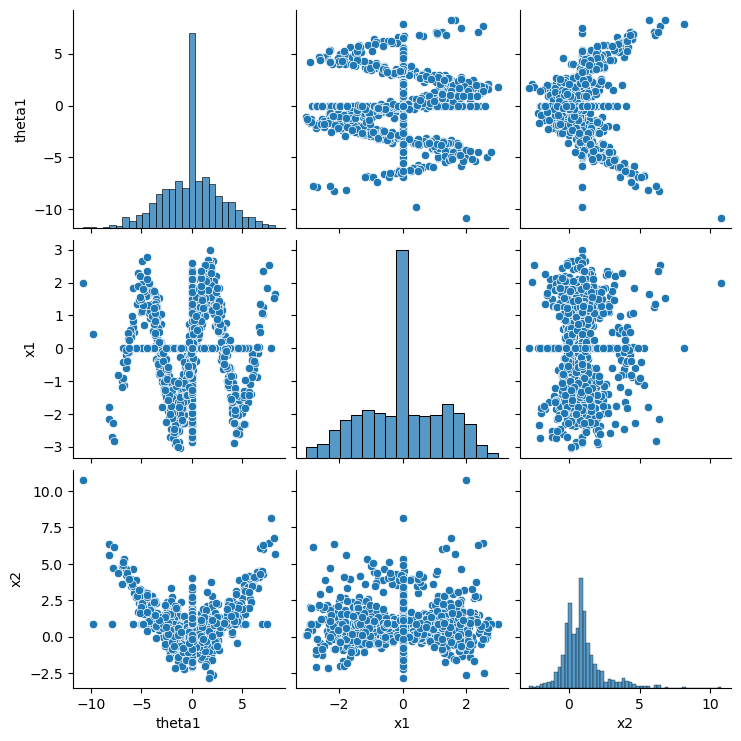

c:\Users\Alexm\anaconda3\Lib\site-packages\sbi\inference\trainers\npe\npe_base.py:169: UserWarning: Beware that there is only a single unique element in the simulated data. If this is intended, make sure to set `z_score_x='none'` as z-scoring would result in NaNs
  warn_if_zscoring_changes_data(x)


 Neural network successfully converged after 412 epochs.

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

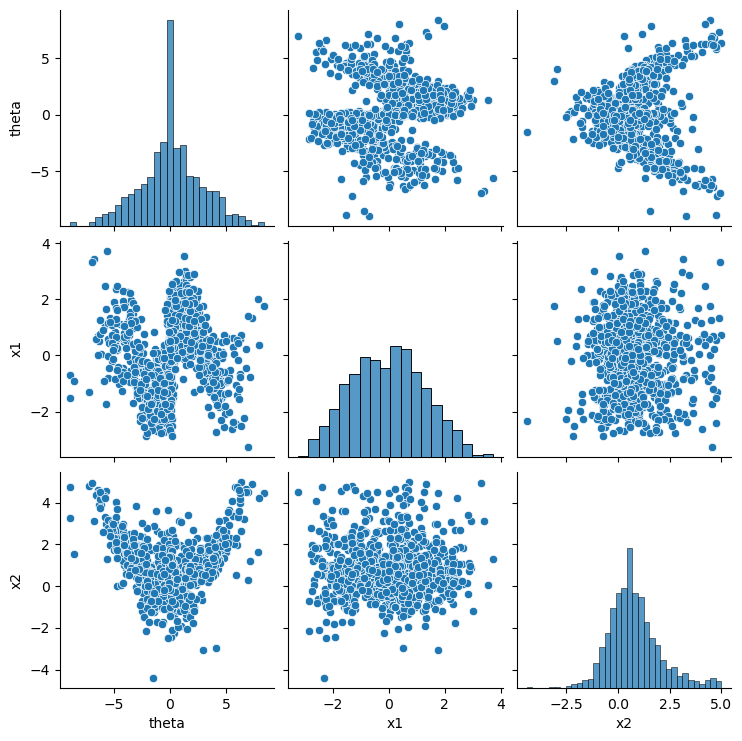

Distribution Similarity Metrics:
nan_percentage: {'original': 14.7, 'generated': 0.0}
wasserstein_distance: 0.28455779190433333
ks_statistic: 0.08268355207538866
ks_pvalue: 0.027395966941724845
jensen_shannon_divergence: 0.14990360934287592
correlation: 0.023779975672564138
stat_diff_mean: 0.10532597731798887
stat_diff_std: 0.25366373856862384
stat_diff_25%: 0.37990053217314806
stat_diff_50%: 0.06433752248995006
stat_diff_75%: 0.29260094960530597
overall_similarity: 0.6027348733497611


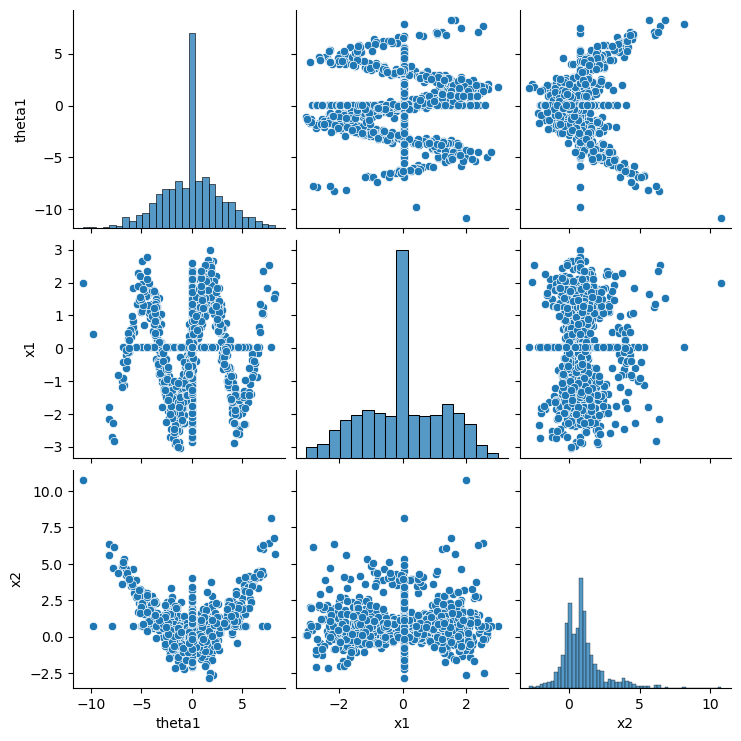

c:\Users\Alexm\anaconda3\Lib\site-packages\sbi\inference\trainers\npe\npe_base.py:169: UserWarning: Beware that there is only a single unique element in the simulated data. If this is intended, make sure to set `z_score_x='none'` as z-scoring would result in NaNs
  warn_if_zscoring_changes_data(x)


 Neural network successfully converged after 335 epochs.

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

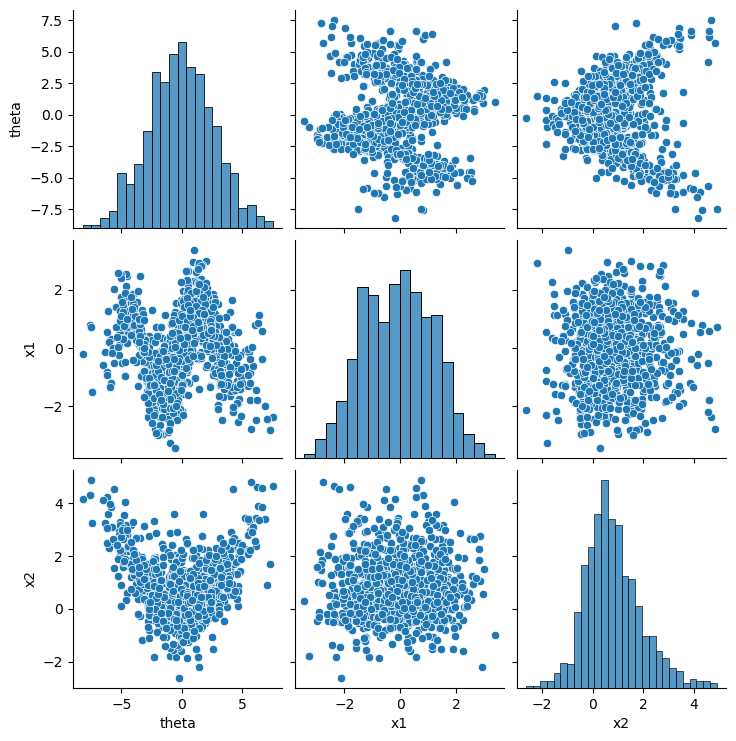

Distribution Similarity Metrics:
nan_percentage: {'original': 14.7, 'generated': 0.0}
wasserstein_distance: 0.2634255728260157
ks_statistic: 0.06746923210025485
ks_pvalue: 0.1549481378100694
jensen_shannon_divergence: 0.14544054722298824
correlation: 0.01564983729702712
stat_diff_mean: 0.075771012964348
stat_diff_std: 0.31669366359710693
stat_diff_25%: 0.19339936164518198
stat_diff_50%: 0.09167682534704606
stat_diff_75%: 0.29162471493085224
overall_similarity: 0.5724312025412803


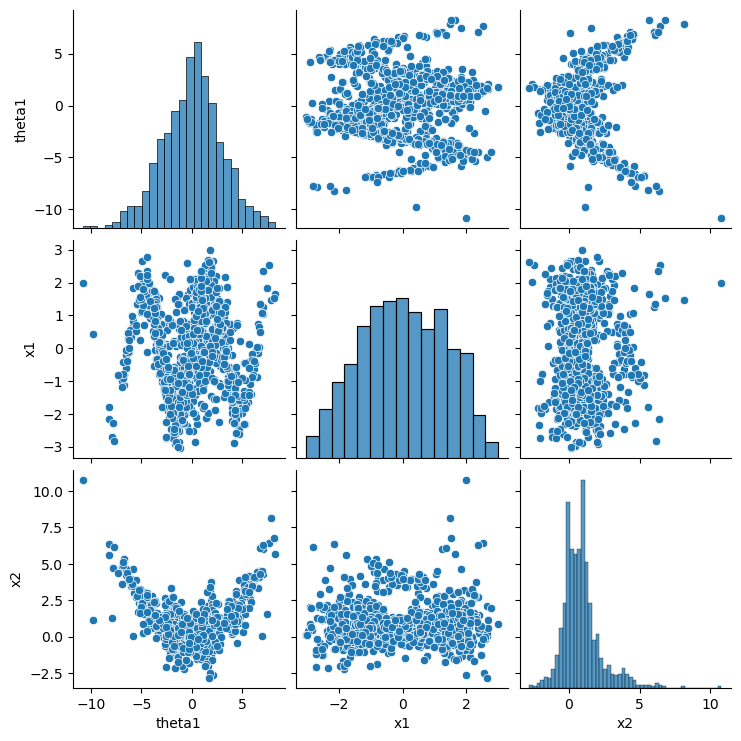

c:\Users\Alexm\anaconda3\Lib\site-packages\sbi\inference\trainers\npe\npe_base.py:169: UserWarning: Beware that there is only a single unique element in the simulated data. If this is intended, make sure to set `z_score_x='none'` as z-scoring would result in NaNs
  warn_if_zscoring_changes_data(x)


 Neural network successfully converged after 103 epochs.

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

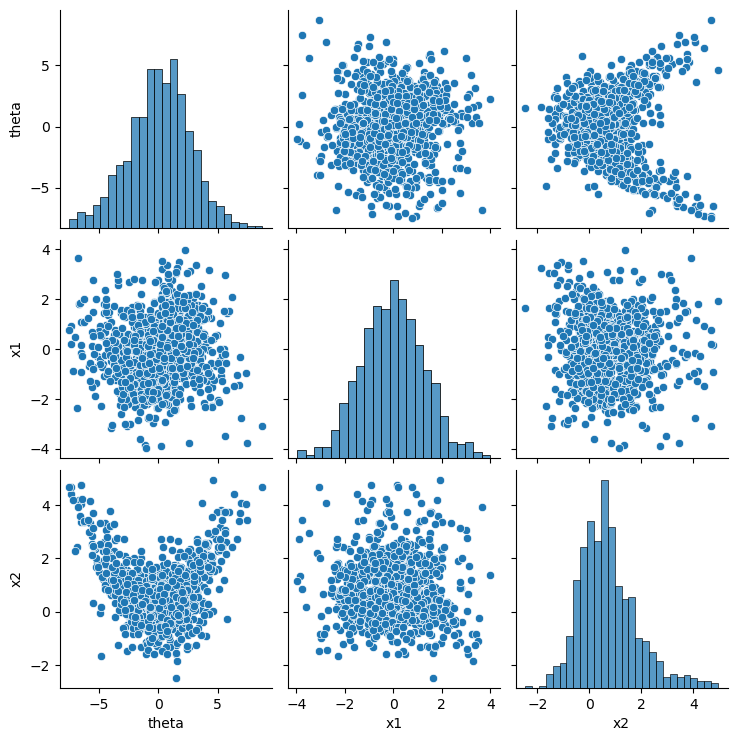

Distribution Similarity Metrics:
nan_percentage: {'original': 14.7, 'generated': 0.0}
wasserstein_distance: 0.3259892759680964
ks_statistic: 0.09910482839314268
ks_pvalue: 0.0010997492440397347
jensen_shannon_divergence: 0.15364277396775114
correlation: 0.02548013765463431
stat_diff_mean: 0.10166350038101275
stat_diff_std: 0.31606117884318036
stat_diff_25%: 0.3331715753301978
stat_diff_50%: 0.14435988323142132
stat_diff_75%: 0.2749927192926407
overall_similarity: 0.6206613464387809


In [92]:
import jax.numpy as jnp
import jax.random as jrandom
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.impute import KNNImputer
import torch
from sbi import utils as sbi_utils
from sbi.inference import SNPE

# Helper function to handle NaN values
def handle_nan(data, method="median"):
    """
    Handles NaN values in the dataset based on the specified method.

    Parameters:
        data (np.ndarray): Input data array with potential NaN values.
        method (str): The method to handle NaN values. Options are:
                      - "zero": Replace NaN with 0.
                      - "mean": Replace NaN with mean of other rows.
                      - "median": Replace NaN with median of other rows.
                      - "knn": Use KNN Imputer to replace NaNs.
    Returns:
        np.ndarray: The array with NaN values handled.
    """
    df = pd.DataFrame(data)  # convert to DataFrame for ease of NaN handling

    if method == "zero":
        return df.fillna(0).values
    elif method == "mean":
        return df.fillna(df.mean()).values
    elif method == "median":
        return df.fillna(df.median()).values
    elif method == "knn":
        imputer = KNNImputer(n_neighbors=3)  # KNN with 3 neighbors
        return imputer.fit_transform(df)
    else:
        raise ValueError("Invalid method specified for NaN handling.")


for method in ["zero", "mean", "median", "knn"]:
    # Step 1: Generate and handle NaNs in the data
    key = jrandom.PRNGKey(42)


    data = generate_data(key, 1000)
    data_np = np.array(data).reshape(1000,-1)

    # Apply NaN handling
    data_np = handle_nan(data_np, method)  # Choose any method: "zero", "mean", "median", "knn"

    # Step 2: Pairplot
    sns.pairplot(pd.DataFrame(data_np, columns=["theta1", "x1", "x2"]))
    plt.show()

    # Step 3: Combine theta, x1, and x2 into the sample space
    parameters = torch.tensor(data_np, dtype=torch.float32)  # Combined theta, x1, x2

    # Use empty observations as we only care about sampling the joint distribution
    observations = torch.zeros(parameters.size(0), 1, dtype=torch.float32)  # Dummy observations

    # Define a wide prior over the combined space
    prior = sbi_utils.BoxUniform(
        low=torch.tensor([-9.0, -5.0, -5.0]),
        high=torch.tensor([9.0, 5.0, 5.0])
    )

    # Initialize and train the SBI model on the combined space
    inference = SNPE(prior)
    density_estimator = inference.append_simulations(parameters, observations).train()

    # Sample from the joint posterior distribution directly
    posterior = inference.build_posterior(density_estimator)

    # Set a default observation context
    posterior.set_default_x(observations[0])

    # Sample 1000 samples from the joint posterior
    posterior_samples = posterior.sample((1000,))

    # Convert to numpy for plotting
    posterior_samples_np = np.array(posterior_samples)

    # Plot the joint distribution using a pairplot
    sns.pairplot(pd.DataFrame(posterior_samples_np, columns=["theta", "x1", "x2"]))
    plt.show()

    data = generate_data(key, 1000)
    data_np = np.array(data).reshape(1000,-1)
    similarity_results = compute_distribution_similarity(data_np, posterior_samples_np)

    # Print results
    print("Distribution Similarity Metrics:")
    for metric, value in similarity_results.items():
        print(f"{metric}: {value}")


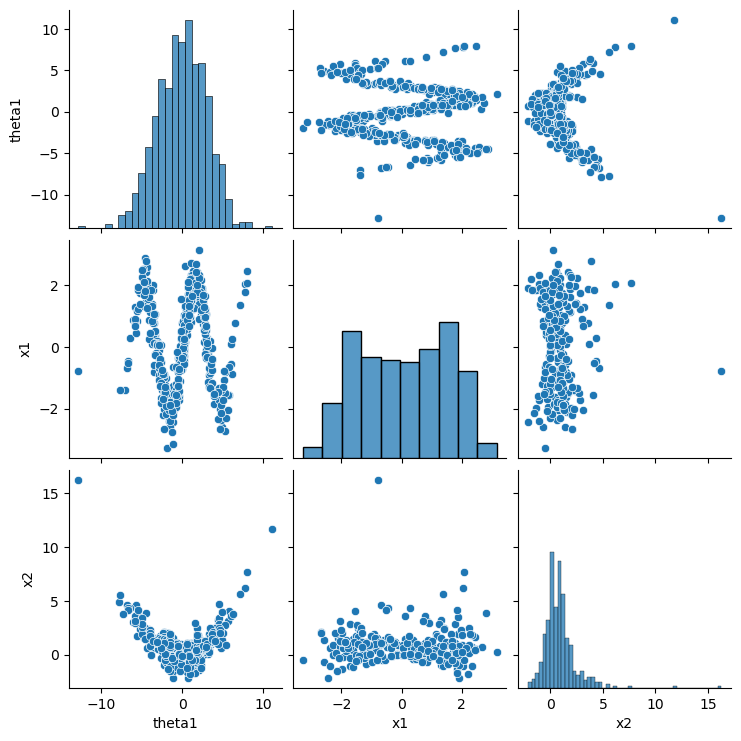

In [67]:
import pandas as pd
# Convert to Pandas DataFrame
df = pd.DataFrame(data.reshape(n, -1), columns=['theta1', 'x1', 'x2'])

# Visualize with a pairplot
sns.pairplot(df)
plt.show()

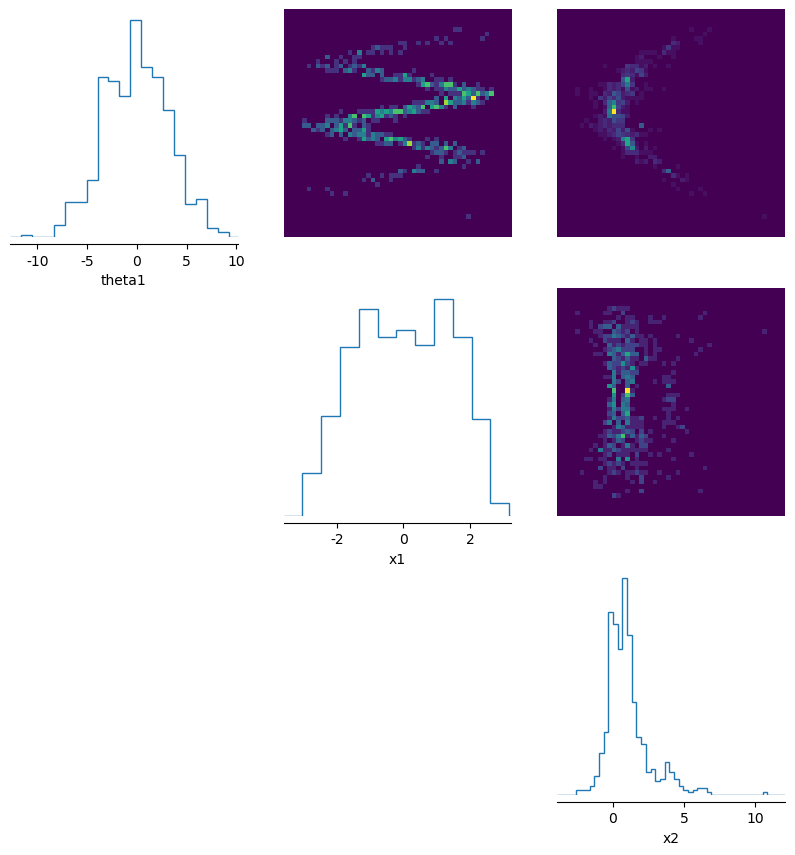

In [93]:
data_np = np.array(data).reshape(1000, -1)
data_clean = data_np[~np.isnan(data_np).any(axis=1)]  # Remove rows with NaNs

# Plot using sbi's pairplot function
pairplot(data_clean, labels=['theta1', 'x1', 'x2'])
plt.show()

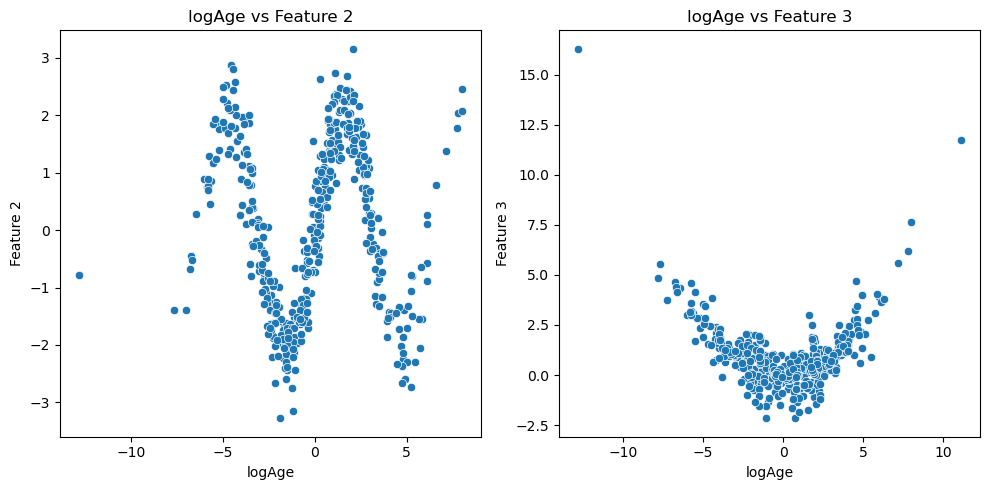

In [69]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

def plot_logAge_vs_features(data, features_per_plot=5, figsize=(5, 5)):
    """
    Plots scatter plots comparing the first feature (logAge/y) and each other feature dynamically.
    The input data has the shape (n_samples, n_features, 1), where the last dimension is singleton.

    Args:
        data (np.array): The data array with shape (n_samples, n_features, 1).
        features_per_plot (int): Number of features to include in each figure.
        figsize (tuple): The size of each subplot figure.
    """
    # Remove the last dimension (singleton dimension)
    data = np.squeeze(data, axis=-1)  # Resulting shape: (n_samples, n_features)

    # Separate the first feature (logAge) and the remaining features
    log_age = data[:, 0]  # First feature
    features = data[:, 1:]  # All other features

    # Number of features (excluding logAge)
    num_features = features.shape[1]

    # Generate labels dynamically for features
    labels = [f"Feature {i+1}" for i in range(1, num_features + 1)]

    # Create a DataFrame for plotting
    df = pd.DataFrame(features, columns=labels)
    df['logAge'] = log_age

    # Determine how many figures to create based on `features_per_plot`
    num_plots = int(np.ceil(num_features / features_per_plot))

    for plot_idx in range(num_plots):
        # Subset of features for the current figure
        start_idx = plot_idx * features_per_plot
        end_idx = min(start_idx + features_per_plot, num_features)
        subset_labels = labels[start_idx:end_idx]
        num_current_features = len(subset_labels)

        # Create a new figure for each subset of features
        fig, axes = plt.subplots(1, num_current_features, figsize=(figsize[0] * num_current_features, figsize[1]))

        if num_current_features == 1:
            axes = [axes]  # Ensure axes is iterable if there's only 1 plot

        # Plot each scatter plot between logAge and the corresponding feature
        for i, label in enumerate(subset_labels):
            sns.scatterplot(x='logAge', y=label, data=df, ax=axes[i])
            axes[i].set_title(f'logAge vs {label}')
            axes[i].set_xlabel("logAge")  # X-axis is logAge
            axes[i].set_ylabel(label)  # Y-axis is the compared feature

        # Adjust layout to prevent overlapping
        plt.tight_layout()
        plt.show()

# Example usage
# Assuming 'data' is your data array of shape (1000, 28, 1)
plot_logAge_vs_features(np.array(data), features_per_plot=5)


### 2) Setting up the diffusion process

We will use the VESDE i.e. the variance exploding stochastic differential equation. 

In [94]:
# VESDE (Variance Exploding Stochastic Differential Equation) is a type of diffusion model 
# used in score-based generative models, where the noise level (variance) increases over time.

# T: Total diffusion time (1.0 indicates the upper bound for the diffusion process time).
T = 1. 

# T_min: Minimum time for the diffusion process. Helps avoid numerical instability (1e-2 here).
T_min = 1e-2 

# sigma_min: Minimum noise (variance) level for the diffusion process, set to 1e-3. 
# Controls how much noise is added to the data at the start of the process.
sigma_min = 1e-3 

# sigma_max: Maximum noise (variance) level for the diffusion process, set to 15. 
# Controls the maximum noise added at the end of the process.
sigma_max = 15. 

# p0: The initial probability distribution over the data. In this case, it's modeled as an 
# independent distribution (Empirical distribution) based on the actual dataset.
# Empirical(data) models the observed data as a distribution (non-parametric).
# Independent() makes sure the data samples are treated as independent.
p0 = Independent(Empirical(data), 1)

# sde: The VESDE model instance is created using the empirical data distribution and the 
# provided minimum/maximum sigma values. VESDE defines how noise (variance) evolves over time.
sde = VESDE(p0, sigma_min=sigma_min, sigma_max=sigma_max)

# Scaling function for the output of the score model (a neural network predicting the data score).
# The score model will output the gradient of the log probability of the data w.r.t. the noisy data,
# and this function scales that output.
def output_scale_fn(t, x):
    # Get the standard deviation of the marginal distribution at time t for data x.
    # The function sde.marginal_stddev computes this based on the time t and data x.
    # jnp.ones_like(x) ensures that we compute this for all elements in x.
    scale = jnp.clip(sde.marginal_stddev(t, jnp.ones_like(x)), 1e-2, None)
    
    # Scale the score model's output using the inverse of the standard deviation.
    # This step makes the score model's predictions stable and well-behaved.
    # 1/scale multiplies the input x to normalize its output.
    # reshape(x.shape) ensures the output retains the same shape as input x.
    return (1/scale * x).reshape(x.shape)


### 3) Building the Simformer

This can be divided into two parts, each offering various choices:

* **Tokenizer**: 
This component jointly embeds 'x', 'node_ids', and the 'condition_mask' into a unified 
vector known as a token.
    * **Value Embedding**: Embeds the value of the variable.
    * **Node Embedding**: Embeds the node ID.
    * **Condition Embedding**: Embeds the condition mask.
* **Transformer**: This is a transformer model that takes tokens as input and generates scores for each node.
    * **Num_heads**: Specifies the number of heads in the multi-head attention mechanism.
    * **Attn_size**: Determines the size of attention, i.e., the dimensions to which query and key are projected.
    * **Num_layers**: Sets the number of layers in the transformer.
    * **Widening_factor**: Specifies the factor by which the hidden size of the MLP is increased in each layer.

In this example, we construct a compact Simformer with 2 layers and 2 heads.


In [95]:
def create_nan_mask(data: Array) -> Array:
    """
    Create a mask for NaN values in the data where True indicates valid (non-NaN) values
    and False indicates NaN values.
    
    Args:
        data (Array): Input data of shape (batch_size, seq_len, features)
    
    Returns:
        Array: Boolean mask of shape (batch_size, seq_len, seq_len)
    """
    # Create mask where False indicates NaN values
    nan_mask = ~jnp.isnan(data[..., 0])  # Using first feature dimension
    
    # Create attention mask matrix where both row and column are masked if either contains NaN
    # Outer product of valid positions with themselves
    attention_mask = jnp.einsum('bi,bj->bij', nan_mask, nan_mask)
    
    return attention_mask

In [96]:
dim_value = 20      # Size of the value embedding
dim_id = 20         # Size of the node id embedding
dim_condition = 10  # Size of the condition embedding


def model(t: Array, x: Array, node_ids: Array, condition_mask: Array, edge_mask: Optional[Array]=None):
    """Simplified Simformer model with NaN handling.
    Args:
        t (Array): Diffusion time
        x (Array): Value of the nodes
        node_ids (Array): Id of the nodes
        condition_mask (Array): Condition state of the nodes
        edge_mask (Array, optional): Edge mask. Defaults to None.
    Returns:
        Array: Score estimate of p(x_t)
    """
    # Get the batch size and sequence length from the shape of 'x'
    batch_size, seq_len, _ = x.shape
    
    # Create NaN mask
    nan_attention_mask = create_nan_mask(x)
    x = jnp.nan_to_num(x, nan=0.0)  # Replace NaNs with 0
    # Combine with existing edge_mask if provided
    if edge_mask is not None:
        edge_mask = edge_mask & nan_attention_mask
    else:
        edge_mask = nan_attention_mask
        
    # Prepare the condition_mask to ensure it is boolean and reshape it
    condition_mask = condition_mask.astype(jnp.bool_).reshape(-1, seq_len, 1)
    # Reshape node_ids for proper tokenization and embedding
    node_ids = node_ids.reshape(-1, seq_len)
    # Reshape diffusion time 't' to broadcast across the nodes
    t = t.reshape(-1, 1, 1)
    
    # Diffusion time embedding net
    embedding_time = GaussianFourierEmbedding(64)
    time_embeddings = embedding_time(t)
    
    # Tokenization part
    embedding_net_value = lambda x: jnp.repeat(x, dim_value, axis=-1)
    embedding_net_id = hk.Embed(nodes_max, dim_id, w_init=hk.initializers.RandomNormal(stddev=3.))
    condition_embedding = hk.get_parameter("condition_embedding", shape=(1,1,dim_condition), 
                                        init=hk.initializers.RandomNormal(stddev=0.5))
    condition_embedding = condition_embedding * condition_mask
    condition_embedding = jnp.broadcast_to(condition_embedding, (batch_size, seq_len, dim_condition))
    
    # Replace NaN values with zeros before embedding
    x = jnp.nan_to_num(x, nan=0.0)
    
    # Embed inputs and broadcast
    value_embeddings = embedding_net_value(x)
    id_embeddings = embedding_net_id(node_ids)
    value_embeddings, id_embeddings = jnp.broadcast_arrays(value_embeddings, id_embeddings)
    
    # Concatenate embeddings
    x_encoded = jnp.concatenate([value_embeddings, id_embeddings, condition_embedding], axis=-1)
    
    # Transformer part
    model = Transformer(num_heads=2, num_layers=2, attn_size=10, widening_factor=3)
    
    # Apply transformer with combined mask
    h = model(x_encoded, context=time_embeddings, mask=edge_mask)
    
    # Decode
    out = hk.Linear(1)(h)
    out = output_scale_fn(t, out)
    return out


In [97]:
# In Haiku, we need to initialize the model first, before we can use it.
init, model_fn = hk.without_apply_rng(hk.transform(model)) # Init function initializes the parameters of the model, model_fn is the actual model function (which takes the parameters as first argument, hence is a "pure function")
# put data into the model i guess
params = init(key, jnp.ones(data.shape[0]), data, node_ids, jnp.zeros_like(node_ids))

In [98]:
# Here we can see the total number of parameters and their shapes
print("Total number of parameters: ", jax.tree_util.tree_reduce(lambda x,y: x+y, jax.tree_map(lambda x: x.size, params)))
jax.tree_util.tree_map(lambda x: x.shape, params) # Here we can see the shapes of the parameters

Total number of parameters:  45774


{'embed': {'embeddings': (3, 20)},
 'gaussian_fourier_embedding': {'B': (33, 1)},
 'linear': {'b': (1,), 'w': (50, 1)},
 'transformer/layer_norm': {'offset': (50,), 'scale': (50,)},
 'transformer/layer_norm_1': {'offset': (50,), 'scale': (50,)},
 'transformer/layer_norm_2': {'offset': (50,), 'scale': (50,)},
 'transformer/layer_norm_3': {'offset': (50,), 'scale': (50,)},
 'transformer/layer_norm_4': {'offset': (50,), 'scale': (50,)},
 'transformer/linear': {'b': (150,), 'w': (50, 150)},
 'transformer/linear_1': {'b': (50,), 'w': (150, 50)},
 'transformer/linear_2': {'b': (50,), 'w': (64, 50)},
 'transformer/linear_3': {'b': (150,), 'w': (50, 150)},
 'transformer/linear_4': {'b': (50,), 'w': (150, 50)},
 'transformer/linear_5': {'b': (50,), 'w': (64, 50)},
 'transformer/multi_head_attention/key': {'b': (20,), 'w': (50, 20)},
 'transformer/multi_head_attention/linear': {'b': (50,), 'w': (20, 50)},
 'transformer/multi_head_attention/query': {'b': (20,), 'w': (50, 20)},
 'transformer/multi

### 4) The loss
Here we will show the variant which targets to learn:

* Correct joint $p(\theta,x_1, x_2)$
* Correct conditionals $p(\theta|x), p(x|\theta), ...$
* Correct marginals $p(\theta), p(x), ...$
    
Base loss is an **denoising score matching objective**:
$$ \mathcal{L}(\phi) = \mathbb{E}_{t \sim Unif(0,1)} \left[ \lambda(t) \mathbb{E}_{x_0, x_t \sim p(x_0)p(x_t|x_0)}\left[ || s_\phi(x_t, t) - \nabla_{x_t} \log p(x_t|x_0)||_2^2 \right] \right] $$
all the different *targets* will be implemented through masking out different things.

In [99]:
import jax
import jax.numpy as jnp
from jax.random import PRNGKey

from functools import partial

from typing import Optional, Sequence, Union, Callable
from jaxtyping import PyTree, Array

def weight_fn(t: Array):
    # Function to calculate weighting based on diffusion process at time 't'.
    # sde.diffusion(t, jnp.ones((1,1,1))) computes diffusion for all ones input,
    # which is squared and clipped to ensure it's not too small (bounded by 1e-4).
    return jnp.clip(sde.diffusion(t, jnp.ones((1,1,1)))**2, 1e-4)

def marginalize(rng: PRNGKey, edge_mask: Array):
    # Function that removes a random node from the graph's adjacency matrix, 
    # setting all its edges to False except the self-connection (diagonal).
    
    # Randomly select a node to marginalize.
    idx = jax.random.choice(rng, jnp.arange(edge_mask.shape[0]), shape=(1,), replace=False)
    
    # Set the selected node's edges to False (no connections).
    edge_mask = edge_mask.at[idx, :].set(False)  # Remove outgoing edges
    edge_mask = edge_mask.at[:, idx].set(False)  # Remove incoming edges
    edge_mask = edge_mask.at[idx, idx].set(True) # Keep the self-loop
    
    return edge_mask

def denoising_score_matching_loss(
    params: PyTree,
    key: PRNGKey,
    times: Array,
    xs_target: Array,
    loss_mask: Optional[Array],
    *args,
    model_fn: Callable,
    mean_fn: Callable,
    std_fn: Callable,
    weight_fn: Callable,
    axis: int = -2,
    rebalance_loss: bool = False,
    **kwargs,
) -> Array:
    """Enhanced denoising score matching loss with improved NaN handling.
    
    Args:
        params (PyTree): Parameters of the model_fn given as a PyTree.
        key (PRNGKey): Random generator key.
        times (Array): Time points, should be broadcastable to shape (batch_size, 1).
        xs_target (Array): Target distribution.
        loss_mask (Optional[Array]): Mask for the target distribution.
        model_fn (Callable): Score model that takes parameters, times, and samples as input.
        mean_fn (Callable): Mean function of the SDE.
        std_fn (Callable): Std function of the SDE.
        weight_fn (Callable): Weight function for the loss.
        axis (int, optional): Axis to sum over. Defaults to -2.
        rebalance_loss (bool, optional): Whether to rebalance loss based on valid elements.
    
    Returns:
        Array: Computed loss value
    """
    # Create NaN mask (True for non-NaN values)
    nan_mask = ~jnp.isnan(xs_target)
    
    # Generate random noise
    eps = jax.random.normal(key, shape=xs_target.shape)
    
    # Replace NaN values with zeros for mean and std computation
    xs_target_clean = jnp.nan_to_num(xs_target, 0.0)
    
    # Compute mean and standard deviation
    mean_t = mean_fn(times, xs_target_clean)
    std_t = std_fn(times, xs_target_clean)
    
    # Generate noisy samples
    xs_t = mean_t + std_t * eps
    
    # Apply loss mask if provided
    if loss_mask is not None:
        loss_mask = loss_mask.reshape(xs_target.shape)
        # Combine loss mask with nan mask
        combined_mask = loss_mask & nan_mask
        xs_t = jnp.where(combined_mask, xs_target_clean, xs_t)
    else:
        combined_mask = nan_mask
        xs_t = jnp.where(nan_mask, xs_target_clean, xs_t)
    
    # Compute score predictions
    score_pred = model_fn(params, times, xs_t, *args, **kwargs)
    score_target = -eps / std_t
    
    # Compute squared error
    loss = (score_pred - score_target) ** 2
    
    # Apply masking to loss
    if loss_mask is not None:
        # Zero out loss for masked values and NaNs
        loss = jnp.where(combined_mask, 0.0, loss)
    else:
        # Zero out loss for NaNs
        loss = jnp.where(nan_mask, 0.0, loss)
    
    # Apply weighting
    weighted_loss = weight_fn(times) * jnp.sum(loss, axis=axis, keepdims=True)
    
    # Rebalance loss if requested
    if rebalance_loss:
        # Count valid (non-masked, non-NaN) elements
        valid_elements = jnp.sum(~combined_mask if loss_mask is not None else ~nan_mask, 
                               axis=axis, keepdims=True)
        weighted_loss = jnp.where(valid_elements > 0, 
                                weighted_loss / valid_elements, 
                                0.0)
    
    # Compute mean loss
    final_loss = jnp.mean(weighted_loss)
    
    # Add diagnostics (can be removed in production)
    diagnostics = {
        'nan_ratio': jnp.mean(jnp.isnan(xs_target)),
        'masked_ratio': jnp.mean(~combined_mask if loss_mask is not None else ~nan_mask),
        'zero_loss_ratio': jnp.mean(loss == 0),
        'raw_loss_mean': jnp.mean(loss),
        'weighted_loss_mean': jnp.mean(weighted_loss)
    }
    
    return final_loss, diagnostics

def loss_fn(params: dict, key: PRNGKey, batch_size: int = 1024):
    """Main loss function with NaN handling."""
    # Split random keys
    rng_time, rng_sample, rng_data, rng_condition, rng_edge_mask1, rng_edge_mask2 = jax.random.split(key, 6)
    
    # Generate random times
    times = jax.random.uniform(rng_time, (batch_size, 1, 1), minval=T_min, maxval=1.0)
    
    # Generate batch data
    batch_xs = generate_data(rng_data, batch_size)
    
    # Create NaN mask
    nan_attention_mask = create_nan_mask(batch_xs)
    
    # Node IDs
    ids = node_ids
    
    # Create condition mask
    condition_mask = jax.random.bernoulli(rng_condition, 0.333, 
                                        shape=(batch_xs.shape[0], batch_xs.shape[1]))
    condition_mask_all_one = jnp.all(condition_mask, axis=-1, keepdims=True)
    condition_mask *= condition_mask_all_one
    condition_mask = condition_mask[..., None]
    
    # Create initial edge mask
    edge_mask = jnp.ones((4 * batch_size // 5, batch_xs.shape[1], batch_xs.shape[1]), 
                        dtype=jnp.bool_)
    
    # Apply marginalization
    marginal_mask = jax.vmap(marginalize, in_axes=(0, None))(
        jax.random.split(rng_edge_mask1, (batch_size // 5,)), edge_mask[0])
    
    # Combine masks
    edge_masks = jnp.concatenate([edge_mask, marginal_mask], axis=0)
    edge_masks = jax.random.choice(rng_edge_mask2, edge_masks, shape=(batch_size,), axis=0)
    
    # Combine with NaN mask
    edge_masks = edge_masks & nan_attention_mask
    
    loss, diagnostics = denoising_score_matching_loss(
        params, rng_sample, times, batch_xs, condition_mask,
        model_fn=model_fn,
        mean_fn=sde.marginal_mean,
        std_fn=sde.marginal_stddev,
        weight_fn=weight_fn,
        node_ids=ids,
        condition_mask=condition_mask,
        edge_mask=edge_masks
    )
    
    # Optionally print diagnostics during training
    if jax.process_index() == 0:  # Only print on first device
        print(f"Training diagnostics: {diagnostics}")
    
    return loss


### 5) Training

Simple training loop (compatible with multiple GPUs, TPUs). Here simpy optimizing with Adam for a fixed amount of steps.

In [100]:
optimizer = optax.adam(1e-3)
opt_state = optimizer.init(params)

@partial(jax.pmap, axis_name="num_devices")
def update(params, rng, opt_state):
    loss, grads = jax.value_and_grad(loss_fn)(params, rng)
    
    loss = jax.lax.pmean(loss, axis_name="num_devices")
    grads = jax.lax.pmean(grads, axis_name="num_devices")
    
    updates, opt_state = optimizer.update(grads, opt_state, params=params)
    params = optax.apply_updates(params, updates)
    return loss, params, opt_state

In [101]:
n_devices = jax.local_device_count()
replicated_params = jax.tree_map(lambda x: jnp.array([x] * n_devices), params)
replicated_opt_state = jax.tree_map(lambda x: jnp.array([x] * n_devices), opt_state)

In [110]:
key = jrandom.PRNGKey(0)
for _ in range(30):
    l = 0
    for i in range(100):
        key, subkey = jrandom.split(key)
        loss, replicated_params, replicated_opt_state = update(replicated_params, jax.random.split(subkey, (n_devices,)), replicated_opt_state)
        l += loss[0] /100
    print(l)
params = jax.tree_map(lambda x: x[0], replicated_params)

41.983192
41.73523
41.94591
41.93359
42.03865
41.65507
41.995304
42.01596
41.792023
42.162773
41.730534
42.050655
41.794437
41.629047
41.889744
42.279835
41.442146
41.43402
42.004635
41.713417
41.828503
41.277054
41.48728
42.039024
41.9698
41.65789
41.787365
41.622936
41.784172
41.64897


### 6) Sampling from the joint and the marginals

For this we will implement a simple SDE-based sampler.

In [103]:
end_std = jnp.squeeze(sde.marginal_stddev(jnp.ones(1)))
end_mean = jnp.squeeze(sde.marginal_mean(jnp.ones(1)))
condition_mask = jnp.zeros((nodes_max,))
condition_value = jnp.zeros((nodes_max,))
from probjax.utils.sdeint import sdeint
def drift_backward(t, x, node_ids=node_ids, condition_mask=condition_mask, edge_mask=None, score_fn=model_fn, replace_conditioned=True):
    """Modified drift function with explicit NaN handling"""
    # Reshape inputs for score function
    t_shaped = t.reshape(-1, 1, 1)
    x_shaped = x.reshape(-1, len(node_ids), 1)
    
    # Create attention mask for current state
    attention_mask = jnp.ones((x_shaped.shape[0], len(node_ids), len(node_ids)), dtype=bool)
    if edge_mask is not None:
        attention_mask = attention_mask & edge_mask
    
    # Compute score
    score = score_fn(params, t_shaped, x_shaped, node_ids, 
                    condition_mask[:len(node_ids)], 
                    edge_mask=attention_mask)
    score = score.reshape(x.shape)
    
    # Replace any NaN scores with zeros
    score = jnp.nan_to_num(score, 0.0)
    
    # Compute drift
    f = sde.drift(t, x) - sde.diffusion(t, x)**2 * score
    
    if replace_conditioned:
        f = f * (1 - condition_mask[:len(node_ids)])
    
    return jnp.nan_to_num(f, 0.0)  # Ensure no NaNs in output

def diffusion_backward(t, x, node_ids=node_ids, condition_mask=condition_mask, replace_conditioned=True):
    """Modified diffusion function with explicit NaN handling"""
    b = sde.diffusion(t, x)
    b = jnp.nan_to_num(b, 0.0)  # Replace any NaNs in diffusion term
    
    if replace_conditioned:
        b = b * (1 - condition_mask[:len(node_ids)])
    
    return b

@partial(jax.jit, static_argnums=(1, 3, 7, 8))
def sample_fn(key, shape, node_ids=node_ids, time_steps=500, 
              condition_mask=jnp.zeros((nodes_max,), dtype=int), 
              condition_value=jnp.zeros((nodes_max,)), 
              edge_mask=None, score_fn=model_fn, replace_conditioned=True):
    """Modified sampling function with improved NaN handling and validation"""
    condition_mask = condition_mask[:len(node_ids)]
    key1, key2 = jrandom.split(key, 2)
    
    # Sample from noise distribution at time 1
    x_T = jax.random.normal(key1, shape + (len(node_ids),)) * end_std[node_ids] + end_mean[node_ids]
    
    # Ensure initial state has no NaNs
    x_T = jnp.nan_to_num(x_T, 0.0)
    
    if replace_conditioned:
        x_T = x_T * (1 - condition_mask) + condition_value * condition_mask
    
    # Create default edge mask if none provided
    if edge_mask is None:
        edge_mask = jnp.ones((len(node_ids), len(node_ids)), dtype=bool)
    
    # Setup SDE solver with expanded edge mask
    expanded_edge_mask = jnp.broadcast_to(edge_mask, (shape[0],) + edge_mask.shape)
    
    # Solve backward SDE with vmap
    keys = jrandom.split(key2, shape[0])
    ys = jax.vmap(
        lambda key, x_T: sdeint(
            key,
            lambda t, x: drift_backward(t, x, node_ids, condition_mask, 
                                      edge_mask=edge_mask, score_fn=score_fn, 
                                      replace_conditioned=replace_conditioned),
            lambda t, x: diffusion_backward(t, x, node_ids, condition_mask, 
                                          replace_conditioned=replace_conditioned),
            x_T,
            jnp.linspace(1., T_min, time_steps),
            noise_type="diagonal"
        )
    )(keys, x_T)
    
    # Final NaN cleanup
    return jnp.nan_to_num(ys, 0.0)

# Example usage with validation
def generate_samples_with_validation(key, num_samples=1000):
    """Helper function to generate and validate samples"""
    samples = sample_fn(key, (num_samples,), node_ids)
    
    # Print diagnostic information
    print(f"Generated samples shape: {samples.shape}")
    print(f"Number of NaN values: {jnp.isnan(samples).sum()}")
    print(f"Sample statistics:")
    print(f"Mean: {jnp.mean(samples)}")
    print(f"Std: {jnp.std(samples)}")
    
    return samples

samples = generate_samples_with_validation(jrandom.PRNGKey(0), num_samples=1000)

Generated samples shape: (1000, 500, 3)
Number of NaN values: 0
Sample statistics:
Mean: 0.30745455622673035
Std: 3.2335193157196045


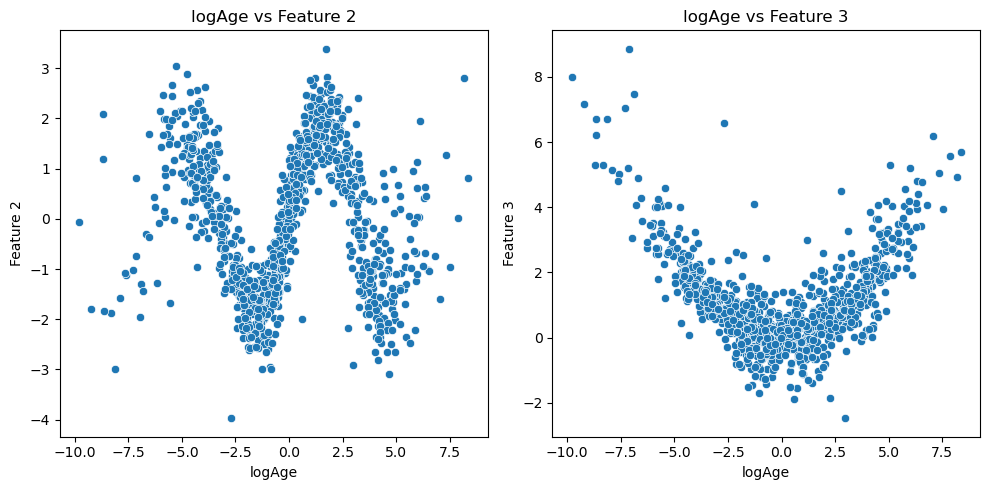

In [104]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

def plot_last_timestep_vs_features(data, features_per_plot=5, figsize=(5, 5)):
    """
    Plots scatter plots comparing the first feature (logAge/y) and each other feature at the last time step.
    The plots are split into manageable figures based on `features_per_plot`.
    
    Args:
        data (np.array): The data array with shape (n_samples, time_steps, n_features).
        features_per_plot (int): Number of features to include in each figure (optional).
        figsize (tuple): The size of each individual subplot (optional).
    """
    # Extract the last time step data
    last_timestep_data = data[:, -1, :]  # Shape: (n_samples, n_features)

    # Separate the first feature (target y) and the other features
    log_age = last_timestep_data[:, 0]  # First feature
    features = last_timestep_data[:, 1:]  # Remaining features

    # Number of features (excluding logAge)
    num_features = features.shape[1]

    # Generate labels dynamically for features
    labels = [f"Feature {i+1}" for i in range(1, num_features + 1)]

    # Create a DataFrame for plotting
    df = pd.DataFrame(features, columns=labels)
    df['logAge'] = log_age

    # Determine how many figures to create based on `features_per_plot`
    num_plots = int(np.ceil(num_features / features_per_plot))

    for plot_idx in range(num_plots):
        # Subset of features for the current figure
        start_idx = plot_idx * features_per_plot
        end_idx = min(start_idx + features_per_plot, num_features)
        subset_labels = labels[start_idx:end_idx]
        num_current_features = len(subset_labels)

        # Create a new figure for each subset
        fig, axes = plt.subplots(1, num_current_features, figsize=(figsize[0] * num_current_features, figsize[1]))

        if num_current_features == 1:
            axes = [axes]  # Ensure axes is iterable if only 1 plot

        for i, label in enumerate(subset_labels):
            sns.scatterplot(x='logAge', y=label, data=df, ax=axes[i])
            axes[i].set_title(f'logAge vs {label}')

        plt.tight_layout()
        plt.show()

# Example usage
# Assuming 'samples' is your data array of shape (1000, 499, 28)
plot_last_timestep_vs_features(np.array(samples), features_per_plot=5)


(1000, 500, 3)


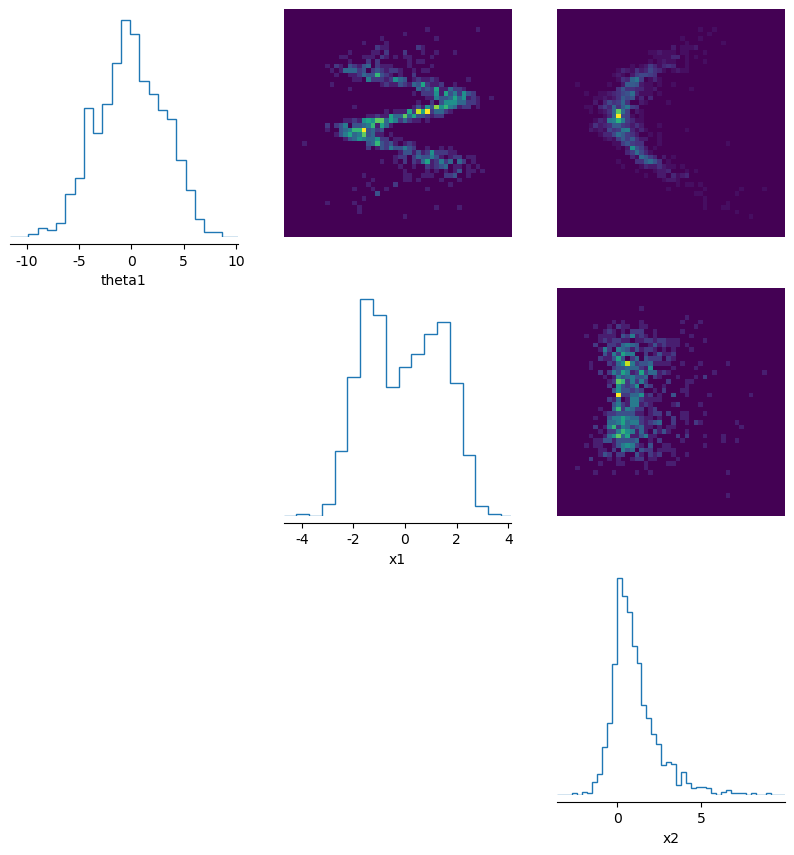

In [105]:
print(samples.shape)
samples_last_timestep = samples[:, -1, :]  # Shape: (n_samples, n_features)
# Plot using sbi's pairplot function
pairplot(np.array(samples_last_timestep), labels=['theta1', 'x1', 'x2'])
plt.show()

In [111]:
data = generate_data(key, 1000)
data_np = np.array(data).reshape(1000,-1)
# Compute distribution similarity
similarity_results2 = compute_distribution_similarity(data_np, samples_last_timestep)
# Print results
print("Distribution Similarity Metrics sim:")
for metric, value in similarity_results2.items():
    print(f"{metric}: {value}")
print("Distribution Similarity Metrics sbi:")
for metric, value in similarity_results.items():
    print(f"{metric}: {value}")

Distribution Similarity Metrics sim:
nan_percentage: {'original': 14.233333333333334, 'generated': 0.0}
wasserstein_distance: 0.1585929986751395
ks_statistic: 0.06380161401349908
ks_pvalue: 0.17711938003132244
jensen_shannon_divergence: 0.13692451338476966
correlation: 0.03989003314525628
stat_diff_mean: 0.10359708219766617
stat_diff_std: 0.04734929402669271
stat_diff_25%: 0.10672441838930051
stat_diff_50%: 0.10435637831687927
stat_diff_75%: 0.18728547294934592
overall_similarity: 0.5275719163296544
Distribution Similarity Metrics sbi:
nan_percentage: {'original': 14.7, 'generated': 0.0}
wasserstein_distance: 0.3259892759680964
ks_statistic: 0.09910482839314268
ks_pvalue: 0.0010997492440397347
jensen_shannon_divergence: 0.15364277396775114
correlation: 0.02548013765463431
stat_diff_mean: 0.10166350038101275
stat_diff_std: 0.31606117884318036
stat_diff_25%: 0.3331715753301978
stat_diff_50%: 0.14435988323142132
stat_diff_75%: 0.2749927192926407
overall_similarity: 0.6206613464387809


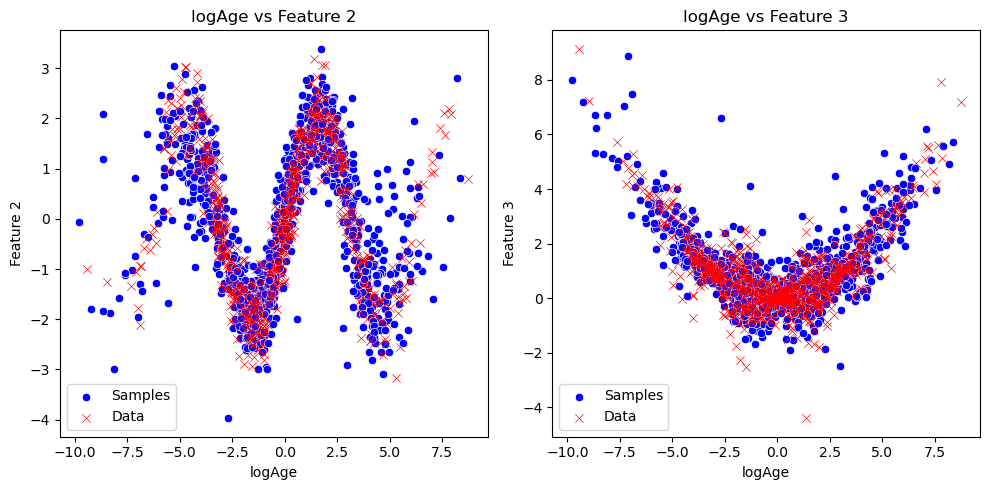

Total Similarity Score (MSE): 4.0453


In [107]:
from sklearn.metrics import mean_squared_error
import numpy as np

def compare_logAge_vs_features(samples, data, features_per_plot=5, figsize=(5, 5)):
    """
    Compares scatter plots of `samples` and `data` on the same axes and computes a similarity score.
    Handles NaN values in the data by ignoring them in the similarity calculation.
    
    Args:
        samples (np.array): The 'samples' data array with shape (n_samples, time_steps, n_features).
        data (np.array): The 'data' array with shape (n_samples, n_features, 1).
        features_per_plot (int): Number of features per plot.
        figsize (tuple): Size of each subplot.
    """
    # Extract last timestep from `samples` and squeeze `data`
    samples_last_timestep = samples[:, -1, :]  # Shape: (n_samples, n_features)
    data_squeezed = np.squeeze(data, axis=-1)  # Shape: (n_samples, n_features)

    # Separate logAge and other features
    log_age_samples = samples_last_timestep[:, 0]
    features_samples = samples_last_timestep[:, 1:]
    log_age_data = data_squeezed[:, 0]
    features_data = data_squeezed[:, 1:]

    # Generate feature labels
    num_features = features_samples.shape[1]
    labels = [f"Feature {i+1}" for i in range(1, num_features + 1)]

    # Create DataFrames for easy plotting
    df_samples = pd.DataFrame(features_samples, columns=labels)
    df_samples['logAge'] = log_age_samples
    df_data = pd.DataFrame(features_data, columns=labels)
    df_data['logAge'] = log_age_data

    # Plotting
    num_plots = int(np.ceil(num_features / features_per_plot))

    for plot_idx in range(num_plots):
        start_idx = plot_idx * features_per_plot
        end_idx = min(start_idx + features_per_plot, num_features)
        subset_labels = labels[start_idx:end_idx]
        num_current_features = len(subset_labels)

        fig, axes = plt.subplots(1, num_current_features, figsize=(figsize[0] * num_current_features, figsize[1]))

        if num_current_features == 1:
            axes = [axes]

        for i, label in enumerate(subset_labels):
            sns.scatterplot(x='logAge', y=label, data=df_samples, ax=axes[i], label='Samples', marker='o', color='blue')
            sns.scatterplot(x='logAge', y=label, data=df_data, ax=axes[i], label='Data', marker='x', color='red')
            axes[i].set_title(f'logAge vs {label}')
            axes[i].legend()

        plt.tight_layout()
        plt.show()

    # Calculate the mean squared error for each feature, ignoring NaNs
    mse_scores = []
    for i in range(num_features):
        # Extract non-NaN values for the feature
        valid_samples = features_samples[:, i]
        valid_data = features_data[:, i]
        mask = ~np.isnan(valid_samples) & ~np.isnan(valid_data)
        if mask.sum() > 0:  # Only compute MSE if there are valid (non-NaN) values
            mse = mean_squared_error(valid_samples[mask], valid_data[mask])
            mse_scores.append(mse)
        else:
            print(f"No valid data for Feature {i+1}, skipping MSE calculation for this feature.")

    # Calculate the average MSE across features, excluding features with no valid data
    total_similarity_score = np.mean(mse_scores) if mse_scores else np.nan
    print(f"Total Similarity Score (MSE): {total_similarity_score:.4f}")

# Example usage
compare_logAge_vs_features(np.array(samples), np.array(data), features_per_plot=5)


In [108]:
import numpy as np
import pandas as pd
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import random

# Set random seed for reproducibility
np.random.seed(42)

# Create a sample dataset with intentional NaN values
def create_dataset_with_nans(n: int = 1000):
    key1, key2, key3, key4 = jrandom.split(key, 4)
    theta1 = jrandom.normal(key1, (n, 1)) * 3  # Some prior on a parameter, no NaN values here
    x1 = 2 * jnp.sin(theta1) + jrandom.normal(key2, (n, 1)) * 0.5  # Some data generated from the parameter
    x2 = 0.1 * theta1**2 + 0.5 * jnp.abs(x1) * jrandom.normal(key3, (n, 1))  # Some data generated from the parameter
    
    # Introduce NaN values randomly in the dataset, only for x1 and x2
    nan_mask = jrandom.uniform(key4, (n, 2)) < 0.1  # 10% NaNs for x1 and x2, no NaNs in theta1
    data = jnp.concatenate([theta1, x1, x2], axis=1).reshape(n, -1, 1)
    data = jnp.where(jnp.pad(nan_mask[..., None], ((0, 0), (1, 0), (0, 0))), jnp.nan, data)
    
    # Separate y and X, where y is theta1 (the parameter), and X is the data generated
    y = data[:, 0]  # theta1 as the target
    X = data[:, 1:]  # x1 and x2 as the features
    
    # Convert to numpy arrays
    y = np.array(y)
    X = np.array(X).reshape(n, 2)  # Flatten X to 2D for compatibility

    
    return X,y

# Method A: Ignore NaN values
def method_ignore_nans(X, y):
    # Create a mask of rows without NaNs
    mask = ~np.isnan(X).any(axis=1)
    X_cleaned = X[mask]
    y_cleaned = y[mask]
    return X_cleaned, y_cleaned

# Method B: Replace with Median
def method_median_imputation(X, y):
    # Create a copy of the original data
    X_imputed = X.copy()
    
    # Compute column-wise medians, ignoring NaNs
    column_medians = np.nanmedian(X, axis=0)
    
    # Replace NaNs with column medians
    for i in range(X.shape[1]):
        nan_mask = np.isnan(X_imputed[:, i])
        X_imputed[nan_mask, i] = column_medians[i]
    
    return X_imputed, y

# Method C: KNN Imputation
def method_knn_imputation(X, y):
    # Use sklearn's KNNImputer
    imputer = KNNImputer(n_neighbors=5)
    X_imputed = imputer.fit_transform(X)
    return X_imputed, y

# Method D: Replace NaNs with 0
def method_zero_imputation(X, y):
    # Create a copy of the original data
    X_imputed = X.copy()
    
    # Replace NaNs with 0
    X_imputed = np.nan_to_num(X_imputed, nan=0)
    
    return X_imputed, y

# Main demonstration function
def demonstrate_nan_handling():
    # Generate dataset with NaNs
    X, y = create_dataset_with_nans()
    
    # Split methods into a list for easy iteration
    methods = [
        ("Ignore NaNs", method_ignore_nans),
        ("Median Imputation", method_median_imputation),
        ("KNN Imputation", method_knn_imputation),
        ("Zero Imputation", method_zero_imputation)
    ]
    
    print("Original Dataset:")
    print(f"Total samples: {len(y)}")
    print(f"Samples with NaNs: {np.isnan(X).any(axis=1).sum()}")
    
    for method_name, imputation_method in methods:
        print(f"\n--- {method_name} ---")
        
        # Apply imputation method
        X_processed, y_processed = imputation_method(X, y)
        
        # Split the data
        X_train, X_test, y_train, y_test = train_test_split(
            X_processed, y_processed, test_size=0.2, random_state=42
        )
        
        # Simple linear regression (for demonstration)
        coefficients = np.linalg.lstsq(X_train, y_train, rcond=None)[0]
        
        # Predict and compute MSE
        y_pred = X_test @ coefficients
        mse = mean_squared_error(y_test, y_pred)
        
        print(f"Samples after processing: {len(y_processed)}")
        print(f"Mean Squared Error: {mse:.4f}")

# Run the demonstration
demonstrate_nan_handling()

Original Dataset:
Total samples: 1000
Samples with NaNs: 199

--- Ignore NaNs ---
Samples after processing: 801
Mean Squared Error: 7.2909

--- Median Imputation ---
Samples after processing: 1000
Mean Squared Error: 9.7039

--- KNN Imputation ---
Samples after processing: 1000
Mean Squared Error: 9.6905

--- Zero Imputation ---
Samples after processing: 1000
Mean Squared Error: 9.7129
